In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import gensim

from transformers import BertTokenizer

import keras
from keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau
import tensorflow as tf

In [21]:
df_train = pd.read_csv('data/train.txt', delimiter=';', header=None, names=['sentence','label'])
df_val = pd.read_csv('data/val.txt', delimiter=';', header=None, names=['tweet','label'])
df_test = pd.read_csv('data/test.txt', delimiter=';', header=None, names=['tweet','label'])
df_train.head()

,sentence,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [22]:
df_train.groupby('label').count()

,sentence
label,
anger,2159
fear,1937
joy,5362
love,1304
sadness,4666
surprise,572


In [23]:
df_train.drop(df_train[df_train.label == 'surprise'].index, inplace = True)

In [24]:
df_train.groupby('label').count()

,sentence
label,
anger,2159
fear,1937
joy,5362
love,1304
sadness,4666


# Preprocessing

In [25]:
df_train['label'].replace('sadness', 'sad', inplace=True)
df_train['label'].replace('joy', 'happy', inplace=True)

df_train.groupby('label').count()

,sentence
label,
anger,2159
fear,1937
happy,5362
love,1304
sad,4666


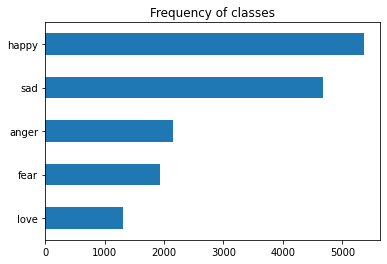

In [26]:
df_train['label'].value_counts(ascending=True).plot.barh()
plt.title('Frequency of classes')
plt.show()

In [27]:
df_train['label'] = df_train['label'].replace('anger', 0)
df_train['label'] = df_train['label'].replace('sad', 1)
df_train['label'] = df_train['label'].replace('fear', 2)
df_train['label'] = df_train['label'].replace('happy', 3)
df_train['label'] = df_train['label'].replace('love', 4)

df_train.rename(columns={'sentence': 'tweet'}, inplace=True)

df_train.label.value_counts()

3    5362
1    4666
0    2159
2    1937
4    1304
Name: label, dtype: int64

In [28]:
df_train.drop_duplicates(inplace= True)
df_train.duplicated().sum()

0

In [29]:
df_train['tweet'] = df_train['tweet'].map(lambda x: x.lower())
df_train.head()

,tweet,label
0,i didnt feel humiliated,1
1,i can go from feeling so hopeless to so damned...,1
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,4
4,i am feeling grouchy,0


In [30]:
df_train['tweet'] = df_train['tweet'].apply(lambda x: re.sub(r"#", "", x))

# Find rows that have hashtags in their text
rows_with_hashtags = df_train['tweet'].str.contains(r'#')

print(rows_with_hashtags.sum())

0


In [31]:
stop_words = set(nltk.corpus.stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

In [32]:
lemmatizer= WordNetLemmatizer()

In [36]:
# from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = PorterStemmer()
# stemmer = factory.create_stemmer()

def lemmatization(text):
    lemmatizer= WordNetLemmatizer()

    text = text.split()

    text=[lemmatizer.lemmatize(y) for y in text]
    
    return " " .join(text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

# def stemming(text):
#     return text.apply(lambda x: [factory.stem(y) for y in x])

def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_URLs(text):
    text = text.replace('[URL]','')
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop_words:
            final_text.append(i.strip())
    return " ".join(final_text)

def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = text.strip()
    return text

def remove_username(text):
    return text.replace('[USERNAME]', '')

#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_username(text)
    text = remove_between_square_brackets(text)
    text = remove_URLs(text)
    text = lemmatization(text)
    text = Removing_numbers(text)
    text = remove_nonaplhanumeric(text)
    # text = stemming(text)
    text = remove_stopwords(text)
    return text

#Apply function on review column
df_train['tweet']=df_train['tweet'].apply(denoise_text)
df_val['tweet']=df_val['tweet'].apply(denoise_text)
df_test['tweet']=df_test['tweet'].apply(denoise_text)

In [41]:
df_train['label'] = df_train['label'].replace('anger', 0)
df_train['label'] = df_train['label'].replace('sad', 1)
df_train['label'] = df_train['label'].replace('fear', 2)
df_train['label'] = df_train['label'].replace('happy', 3)
df_train['label'] = df_train['label'].replace('love', 4)

df_train.label.value_counts()

3    5361
1    4666
0    2159
2    1937
4    1304
Name: label, dtype: int64

In [47]:
df_val['label'] = df_val['label'].replace('anger', 0)
df_val['label'] = df_val['label'].replace('sadness', 1)
df_val['label'] = df_val['label'].replace('fear', 2)
df_val['label'] = df_val['label'].replace('joy', 3)
df_val['label'] = df_val['label'].replace('love', 4)

df_val.label.value_counts()

3    704
1    550
0    275
2    212
4    178
Name: label, dtype: int64

In [43]:
df_val.drop(df_val[df_val.label == 'surprise'].index, inplace = True)

In [46]:
df_test['label'] = df_test['label'].replace('anger', 0)
df_test['label'] = df_test['label'].replace('sadness', 1)
df_test['label'] = df_test['label'].replace('fear', 2)
df_test['label'] = df_test['label'].replace('joy', 3)
df_test['label'] = df_test['label'].replace('love', 4)

df_test.label.value_counts()

3    695
1    581
0    275
2    224
4    159
Name: label, dtype: int64

In [44]:
df_test.drop(df_test[df_test.label == 'surprise'].index, inplace = True)

In [45]:
df_train.to_csv('data/preprocessed_data/data_train_eng.csv')
df_val.to_csv('data/preprocessed_data/data_val_eng.csv')
df_test.to_csv('data/preprocessed_data/data_test_eng.csv')